In [1]:
import numpy as np
import matplotlib.pyplot as plt

from random import randrange

import torch
from torch.nn import Module, Sequential, Linear, Tanh
from torch.distributions import Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device= "cpu"
print(device)

cuda


In [3]:
torch.__version__

'1.12.1+cu116'

In [4]:
pile_sampler = Categorical(torch.tensor([1/2 , 1/2]))
pile_sampler2 = Categorical(torch.tensor([1]))
normal_init = MultivariateNormal(torch.tensor([[2,2],[2,6]]).float(), 0.1*torch.stack([torch.eye(2), torch.eye(2)]))
normal_target = MultivariateNormal(torch.tensor([[6,4]]).float(), 0.1*torch.stack([torch.eye(2)]))
sampler_init = MixtureSameFamily(pile_sampler, normal_init)
sampler_target = MixtureSameFamily(pile_sampler2, normal_target)

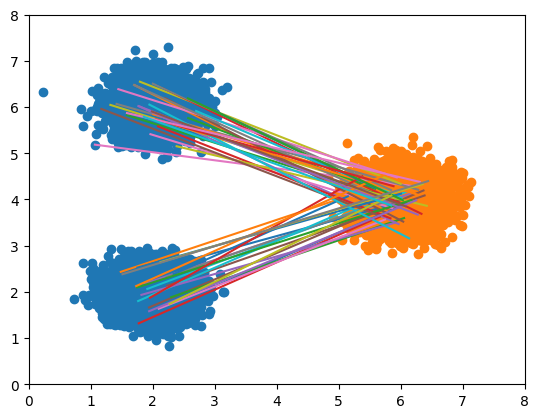

In [5]:
samples_init=sampler_init.sample([10000]).to(device)
samples_target=sampler_target.sample([10000]).to(device)

plt.scatter(samples_init[:,0].cpu().numpy(), samples_init[:,1].cpu().numpy())
plt.scatter(samples_target[:,0].cpu().numpy(), samples_target[:,1].cpu().numpy())
plt.xlim(0, 8)
plt.ylim(0, 8)
pairs_1 = torch.stack([samples_init, samples_target], axis=1)
for pair in range(50):
    plt.plot([pairs_1[pair][0][0].cpu().numpy(), pairs_1[pair][1][0].cpu().numpy()], [pairs_1[pair][0][1].cpu().numpy(), pairs_1[pair][1][1].cpu().numpy()])

In [6]:
class MLP(Module):
    def __init__(self, input_dim, hidden_num):
        super().__init__()
        self.NN = Sequential(Linear(input_dim + 1, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, input_dim, bias=True)
                            )
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.NN(inputs)

        return x

In [7]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model.to(device)

    def get_train_tuple(self, z0, z1):
        # random times
        t = torch.rand((z0.shape[0], 1)).to(device)
        # linear interpolation
        z_t = t* z1 + (1-t) * z0
        # connection line
        target = z1 - z0

        return z_t, t, target


    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0.detach().clone())

        batchsize = z0.shape[0]

        dt = 1./num_steps
        z = z0.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            pred = self.v_model(z, t)
            z = z.detach().clone() + pred * dt

            trajectory.append(z.detach().clone())

        return trajectory


In [8]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
    loss_curve = []
    for i in range(inner_iters + 1):
        optimizer.zero_grad()
        indeces = torch.randperm(len(pairs))[:batchsize]
        batch = pairs[indeces]
        z0 = batch[:, 0].detach().clone()
        z1 = batch[:, 1].detach().clone()
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)
        #print(rectified_flow.v_model.device)

        pred = rectified_flow.v_model(z_t, t)
        loss = (target- pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        loss = loss.mean()
        loss.backward()

        optimizer.step()
        loss_curve.append(loss.item())

    return rectified_flow, loss_curve

In [9]:
def draw_plot(rectified_flow, z0, z1, num_steps):
  z0_1 = MixtureSameFamily(pile_sampler2, MultivariateNormal(torch.tensor([[2,2]]).float(), 0.1*torch.stack([torch.eye(2)]))).sample([10000]).to(device)
  traj_1 = rectified_flow.sample_ode(z0=z0_1, num_steps=num_steps)

  z0_2 = MixtureSameFamily(pile_sampler2, MultivariateNormal(torch.tensor([[2,6]]).float(), 0.1*torch.stack([torch.eye(2)]))).sample([10000]).to(device)
  traj_2 = rectified_flow.sample_ode(z0=z0_2, num_steps=num_steps)
  
  plt.figure(figsize=(4,4))
  plt.xlim(0,8)
  plt.ylim(0,8)
    
  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj_1[0][:, 0].cpu().numpy(), traj_1[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj_1[-1][:, 0].cpu().numpy(), traj_1[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)

  plt.scatter(traj_2[0][:, 0].cpu().numpy(), traj_2[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj_2[-1][:, 0].cpu().numpy(), traj_2[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj_1)
  plt.figure(figsize=(4,4))
  plt.xlim(0,8)
  plt.ylim(0,8)
  plt.axis('equal')
  for i in range(30):
    plt.plot(traj_particles[:, i, 0].cpu().numpy(), traj_particles[:, i, 1].cpu().numpy())
  traj_particles = torch.stack(traj_2)
  for i in range(30):
    plt.plot(traj_particles[:, i, 0].cpu().numpy(), traj_particles[:, i, 1].cpu().numpy())
  plt.title('Transport Trajectory')
  plt.tight_layout()

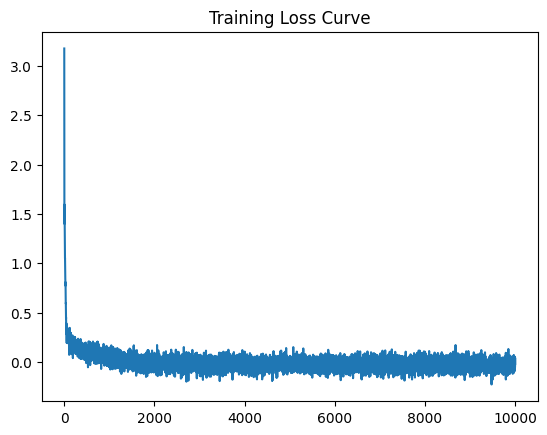

In [10]:
iterations = 10000
batchsize = 2048
input_dim = 2

v_model_1 = MLP(input_dim, hidden_num=100)
rectified_flow_1 = RectifiedFlow(v_model_1)
optimizer = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve_1 = train_rectified_flow(rectified_flow_1, optimizer, pairs_1, batchsize, iterations)
plt.plot(np.log(loss_curve_1))
plt.title("Training Loss Curve")
plt.show()

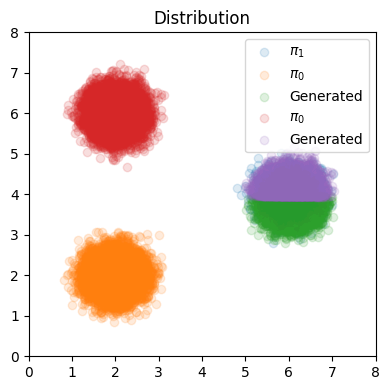

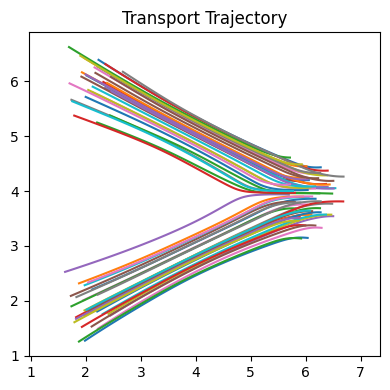

In [11]:
draw_plot(rectified_flow_1, z0=sampler_init.sample([2000]).to(device), z1=sampler_target.sample([2000]).to(device), num_steps=100)

In [12]:
flow_1 = rectified_flow_1.sample_ode(samples_init, 100)
pairs_2 = torch.stack([samples_init, flow_1[:][-1]], axis= 1)

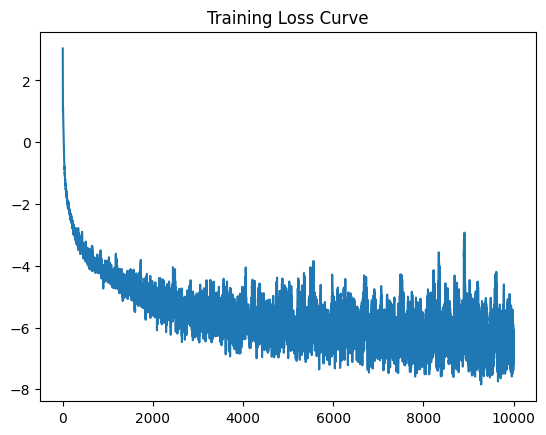

In [13]:
v_model_2 = MLP(input_dim, hidden_num=100)
rectified_flow_2 = RectifiedFlow(v_model_2)
optimizer_2 = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2, optimizer_2, pairs_2, batchsize, iterations)
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

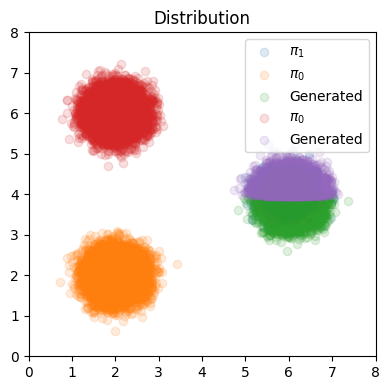

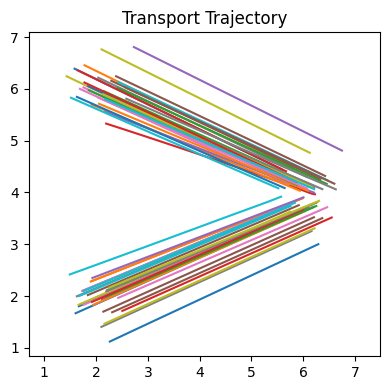

In [14]:
draw_plot(rectified_flow_2, z0=sampler_init.sample([2000]).to(device), z1=sampler_target.sample([2000]).to(device), num_steps=100)

In [15]:
flow_2 = rectified_flow_2.sample_ode(samples_init, 100)
pairs_3 = torch.stack([samples_init, flow_2[:][-1]], axis= 1)

In [24]:
class Distill_model(Module):
    def __init__(self, input_dim, hidden_num):
        super().__init__()
        self.NN = Sequential(Linear(input_dim, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, input_dim, bias=True)
                            )
    
    def forward(self, x_input):
        x = self.NN(x_input)

        return x

In [27]:
def train_distill(distill_model, optimizer, pairs, batchsize, inner_iters):
    loss_curve = []
    for i in range(inner_iters + 1):
        optimizer.zero_grad()
        indeces = torch.randperm(len(pairs))[:batchsize]
        batch = pairs[indeces]
        z0 = batch[:, 0].detach().clone()
        z1 = batch[:, 1].detach().clone()

        pred = distill_model(z0)
        loss = (z1 - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        loss = loss.mean()
        loss.backward()

        optimizer.step()
        loss_curve.append(loss.item())

    return distill_model, loss_curve

In [28]:
distill_model = Distill_model(2, 100).to(device)
optimizer = torch.optim.SGD(distill_model.parameters(), lr=1e-2)
distill_model, loss_curve = train_distill(distill_model, optimizer, pairs_3.to(device), 2048, 10000)

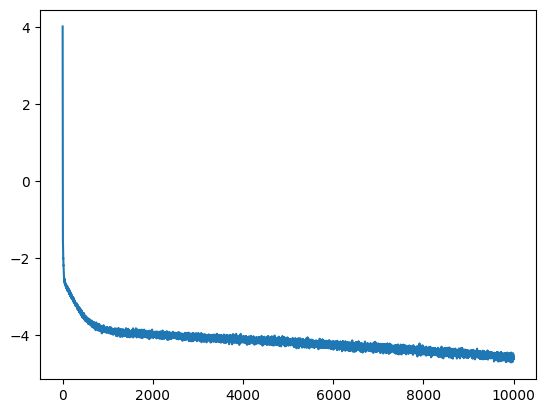

In [30]:
plt.plot(np.log(loss_curve))

In [31]:
distill = distill_model(samples_init)
pairs_2 = torch.stack([samples_init, distill], axis= 1)

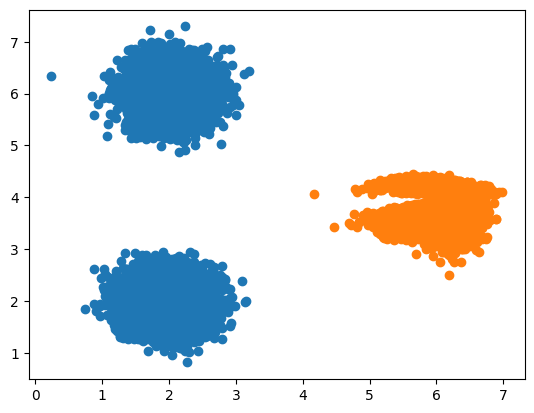

In [36]:
plt.scatter(samples_init[:, 0].cpu().numpy(), samples_init[:, 1].cpu().numpy())
plt.scatter(distill[:,0].detach().cpu().numpy(), distill[:,1].detach().cpu().numpy())
plt.show()